# My <font color='brown'>MNIST</font> Adventure

本模組使用 [MNIST](http://yann.lecun.com/exdb/mnist/) 手寫數字資料庫，學習 sklearn 套件庫分類演算法的使用法以及鍛鍊各種 Python 技巧。


- [The Story of MNIST database (YouTube Video)](https://www.youtube.com/watch?v=oKzNUGz21JM)


接下來我們**要做這些事**：

Part 1

- 從 Yann LeCun 網站下載原始資料
- 解壓縮 gzip
- 解碼 idx 格式檔案 （MNIST only）
- 將 python 資料寫入 pickle
- 顯示單一字元 （用 matplotlib）
- 顯示 16 進位內容

-------
Part2

- 用 mnist 資料做 binary classification
	- Perceptron
- 多元分類
	- Logistic Regression
    - yellowbrick/mlxtend 套件介紹
	- Multiple Layer Perceptron
	- SVM


# ★ Importing libraries

In [36]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/adventures/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '\\Google Drive\\adventures\\'

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=14)

from datetime import datetime
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.20"
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
# import gdown
import requests
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

figure_dir = groot_dir + 'figure\\'
dataroot_dir = groot_dir
mnist_dir = groot_dir + 'mnist\\'

if not os.path.exists(mnist_dir):
    os.mkdir(mnist_dir)

covid_fig = 'covid\\'
mnist_fig = 'mnist\\'

gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300)

local_time = lambda x, offset: x + relativedelta(hours= offset)
def local_now(hours = 8):
    return datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print('Local Time:', local_now())

def print_local_now():
    return print('Local Time:', local_now())

def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath
        
def acct_string(num):
    s0 = str(num)
    if len(s0) <=3:
        return s0  
    num_section = int(len(s0)/3)
    remaining_start = len(s0) % 3
    s = s0[:remaining_start]
    for i in range(num_section):
        s += ',%s' % s0[remaining_start + i*3 :remaining_start + (i+1)*3]   
    return s

TAIWAN_CSV = '1I5yqulrZSHPSQkxT3oqt_3uVAhPolOEP'
RED_WINE = '1ZDg4EfKkkjsWXfs4L3DkZhnAIfnq98Vk'
TITANIC_TRAIN = '1PrxmUKRQWSlYgtMU13l1E0ob4hVJI20O'
JHU_CSSE = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
MNIST_TRAIN = '1E-uJ0zqqAfpsVjoOSzqF5TXhDfPNlkQ5'
MNIST_TRAIN_LABEL = '13clNJ2cd2I90W3DEkDBKjZSDNNEqqx3B'
MNIST_TEST = '1zVpVHJl5YABa3qExt1K-O3WaEHXTJekg'
MNIST_TEST_LABEL = '1qci_-dqubnRN-cdrCsbYaUAxyO7_jH9z'

print('\nThis module is amied to explore MNIST dataset...')

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage root points to ==>', groot_dir)
print('MNIST data will be stored at ==>', mnist_dir)
print('\nLibraries and dependenciess imported')
print_local_now()


This module is amied to explore MNIST dataset...

Running on win32
Python Version 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Data storage root points to ==> C:\Users\TyKA\Google Drive\adventures\
MNIST data will be stored at ==> C:\Users\TyKA\Google Drive\adventures\mnist\

Libraries and dependenciess imported
Local Time: 2021-06-20 14:18:52.143450


## ✔ Show MNIST digit helper 

### Confusion Matrix and ROC Plotter

In [2]:
from sklearn.metrics import r2_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib as mpl
import math
import itertools
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

def tf_diag(a):
    b = np.array(a).copy()
    rev_diag = np.diag(np.array(a))[::-1]
    for i, x  in enumerate(rev_diag):
        b[i][i] = x
    return b

def cm_transform(cm):
    newcm = np.zeros(cm.shape)
    for i in range(cm.shape[0]):
        newcm[i] = cm[:,i]
    return newcm.astype(np.int)

def my_plot_confusion_matrix(y_val, y_hat, target_names,
        title='CSP Confusion Matrix',
        figsize = (8, 6),
        cmap=None,
        normalize=True,
        ax = None):
    """
    given the observed and predicted values delivered by a classifier, make 
    a nice plot of the confusion matrix

    Arguments
    ---------
    y_val       : the observed values
    y_hat       : the predictced values
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                see http://matplotlib.org/examples/color/colormaps_reference.html
                plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                If True, plot the proportions
    """

    cm = confusion_matrix(y_val, y_hat)
    cm = tf_diag(cm) if cm.shape[0] == 2 else cm_transform(cm)

    n_classes = cm.shape[0]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    accuracy = accuracy_score(y_val, y_hat)

    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    else:
        fig = ax.figure

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.rcParams['xtick.labelsize']= 14
    plt.rcParams['ytick.labelsize']= 14
    plt.rcParams['axes.titlesize']= 14

    ax.set_title(title, fontsize = 14)
    fig.colorbar(ScalarMappable(norm=None, cmap=cmap), ax=ax)

    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    ax.set(xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=target_names,
        yticklabels=target_names,
        ylabel="Predicted label",
        xlabel="True label")
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            ax.text(j, i, "{:0.3f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize = 18)
        else:
            ax.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize = 18)

    return ax

print('Loading my confusion matrix plotter ...')
print_local_now()

Loading my confusion matrix plotter ...
Local Time: 2021-06-20 13:34:24.637540


### How to display MNIST digits

- show_mnist_digit(): display bitmapped mnist digit
- show_digit_hex(): show hex value of mnist digit
- numpy.random.[randint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html)

In [3]:
def show_mnist_digit(xdata, ydata, digit_index, add_noise = False, 
    title = None,
    outfile = ''):
    d = xdata[digit_index]
    d = np.reshape(d, (28, 28))
    if add_noise:
        anoise = np.random.randint(0, 100, (28, 28))
        d = d + anoise
    plt.imshow(d, cmap=plt.get_cmap('gray_r'))
    
    plt.title( ('mnist index ' if title is None else title) + f'{digit_index:d} = {ydata[digit_index]:d}' , 
        fontsize = 14)
    if (outfile):
        plt.savefig(gfigure(outfile), dpi = 300)
#     plt.show()
    
def show_digit_hex(data, digit_index):
    # if digit_index >= 10000: return
    d = data[digit_index]
    d = np.reshape(d, (28, 28)).astype(np.int)
    # print('begin show digits\n')
    for row in range(0, 28):
        for col in range(0, 28):
            print("%02X " % d[row][col], end="")
        print("") 

def predict_digit_viask(model, images, labels, to_be_checked = None):
        
    if to_be_checked is None:
        to_be_checked = np.random.randint(1, 10000, 1)
        
    d = images[to_be_checked].reshape(1, 28*28)
    y_guess = model.predict(d)

    # print('classifier %s prediction' % model_name)
    print('test set digit index [%d]' % to_be_checked)
    print('answer = %d , predicted = %d\n' % 
        (labels[to_be_checked], y_guess[0]) )
    
    prob_list = model.predict_proba(d)

    fig, ax = plt.subplots(1, 2, figsize=(10,5))

    ax[0].imshow(images[to_be_checked].reshape(28, 28), 
        cmap=plt.get_cmap('gray_r') )
    
    ax[0].set_title('MNIST Test Set: [%d] = %d' \
        % (to_be_checked, labels[to_be_checked]))
    ax[0].grid(b = 'on', alpha = 0.5, ls = '--')
    ax[1].bar(np.arange(10), prob_list[0])
#     ax[1].set_aspect(0.1)
    ax[1].set_xticks(np.arange(10))
    ax[1].set_yticks(np.arange(0,1.1,0.1))

    ax[1].grid('on', color = '#eeeeee', ls = '--')
    ax[1].set_title('Class %d Probability %0.3f' % (np.argmax(prob_list[0]), max(prob_list[0])))
    plt.tight_layout()
    # output_fig(mnist_fig + 'prediction %d' % to_be_checked)

print('Loading mnist digits plotting helpers')
print_now()

Loading mnist digits plotting helpers
Local Time: 2021-06-20 13:34:24.990414


# ① 下載原始檔 (download idx-coded mnist dataset)




檔案格式說明，參考下列連結：

- Yann LeCunn 網站提供 [idx](http://yann.lecun.com/exdb/mnist/) 格式[說明](http://www.fon.hum.uva.nl/praat/manual/IDX_file_format.html)，mlxtend 也提供以 Python 如以 mlxtend 套件[載入資料庫](http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/)的說明。

- [Kaggle](https://www.kaggle.com/ngbolin/mnist-dataset-digit-recognizer) 上有 csv 格式的說明

- [MNIST Dataset Python Example Using CNN](https://towardsdatascience.com/mnist-cnn-python-c61a5bce7a19)

- [Using MNIST](https://www.python-course.eu/neural_network_mnist.php)

- [np.fromfile](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fromfile.html) API 說明

### MNIST website URL

train_data_file =   'train-images-idx3-ubyte'
train_label_file =  'train-labels-idx1-ubyte'
test_data_file =  't10k-images-idx3-ubyte'
test_label_file =  't10k-labels-idx1-ubyte'

mnist_host = 'http://yann.lecun.com/exdb/mnist/'

mnist_files = [train_data_file, train_label_file, 
    test_data_file, test_label_file]

### 直接從 Yann Lecun 維護的網站下載資料

- [Python GZip](https://docs.python.org/3/library/gzip.html)
- [How to unzip gz file using Python](https://stackoverflow.com/questions/31028815/how-to-unzip-gz-file-using-python)

- [MNIST dataset provided by Yann Lecun](http://yann.lecun.com/exdb/mnist/)

%%time

import gzip
import shutil

def un_gzip(original, uncompressed):
    with gzip.open(original, 'rb') as f_in:
        with open(uncompressed, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            print('%s uncompressed to %s'%(original, uncompressed))

for dfile in mnist_files:
    remote_file = mnist_host + dfile + ".gz"
    local_file = mnist_dir + dfile + ".gz"
    result = mnist_dir + dfile
    
    fetch_file_via_requests(remote_file, mnist_dir)
    un_gzip(local_file, result)
    
print("mnist database fetched")

### 從遠端 Google Drive 下載 ( Fetching shared resources)

fetch_gdrive_file(MNIST_TRAIN, 
    os.path.join(mnist_dir, train_data_file ))
fetch_gdrive_file(MNIST_TRAIN_LABEL, 
    os.path.join(mnist_dir, train_label_file ))
fetch_gdrive_file(MNIST_TEST, 
    os.path.join(mnist_dir, test_data_file ))
fetch_gdrive_file(MNIST_TEST_LABEL, 
    os.path.join(mnist_dir, test_label_file))

## Read dataset and dump pickle  ✔

Yann LeCunn 維護的 MNIST 資料已經下載回來，放在 ～/Google Drive/adventures/mnist/。以下程式將 idx 格式的檔案載入記憶體，以 Pandas DataFrame 格式封裝起來。為了日後使用方便，並將 DataFrame 內容以 Python 內建的 `Pickle` 格式存入本地硬碟。


讀入資料後，分成兩個資料集 `train` & `test`，兩個資料集的 shape 以及資料筆數如下述：

- shape of train_x (60000, 784)
- shape of train_y (60000,)
- shape of test_x (10000, 784)
- shape of test_x (10000,)

dump datafram to pickle 時，應該儲存**沒有處理**過（label smoothing, nomalization）的資料。下次取出來使用的時候，依照當時需求，實驗目的，再做必要的 preprocessing or feature engingeering 即可

### read_idx (要預先載入)

import struct, pickle
from scipy.ndimage.interpolation import shift

def read_idx(filename):
    with open(filename,'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        if (dims == 3):
            n = struct.unpack('>I', f.read(4))[0]
            r = struct.unpack('>I', f.read(4))[0]
            c = struct.unpack('>I', f.read(4))[0]
            shape = (n, r, c)
        else:
            n = struct.unpack('>I', f.read(4))[0]
            shape = (n)
#         print('idx shape =', shape)
        return np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))


### 讀入 idx file，然後寫入 pickle

# read origin data

raw_train = read_idx(mnist_dir + train_data_file)
train_data = np.reshape(raw_train, (60000, 28*28))
train_y = read_idx(mnist_dir + train_label_file)

raw_test = read_idx(mnist_dir + test_data_file)
test_data = np.reshape(raw_test, (10000, 28*28))
test_y = read_idx(mnist_dir + test_label_file)

import pickle

with open(mnist_dir + "clean_mnist.pkl", "bw") as fh:
    data = (train_data, train_y, test_data, test_y)
    pickle.dump(data, fh)

## 也可以使用 fetch_openml 

-  [fetch_openml](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html?highlight=fetch_openml#sklearn.datasets.fetch_openml) API

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
# mnist.keys()

X, y = mnist["data"], mnist["target"]

Train_X, Train_y= X[:60000], y[:60000]
test_X, test_y = X[10000:], y[10000:]

## Load previously stored pickle for demo purpose

Load the pickled mnist digits into data frames **train_data**, **y_train**, test_data and y_test

* 直接從pickel中取出測試數據

(60000, 784) (60000,)
(10000, 784) (10000,)


## How to display hand-written digits ✌

* 取出 id=1107 的文字，並以plt.imshow灰階(gray_r)表示

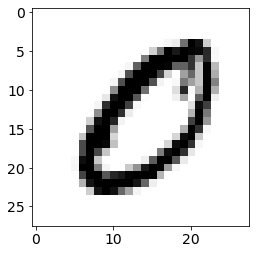

* 建立 show_mnist_digit2(x, y, inx)副程式

In [6]:
def show_mnist_idx2(x, y , idx):


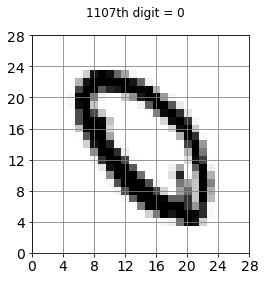

* 建立 show_mnist_hex(x, y, idx) 顯示文字色彩以 hex code 呈現的副程式 \
Note: format(02X) 意指：02 = 2位數呈現，X = 16進位數值呈現 (X大寫表示若對應英文字母，則以大寫表示)

In [8]:
def show_mnist_hex(x, y, idx):


In [9]:
show_mnist_hex(train_data, y_train, 1107)

00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 01 09 11 8F FE EC 31 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 2E 87 FE E6 FE FA F6 D5 07 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 82 FE FE FE FE FE CC 6A D3 06 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 09 A0 FC FE FE FA 9D 9D CC 3A FE 45 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 0A B0 FE FE FE BB 2C 00 5F 97 3A FE 53 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 0A AF FE FE FE AD 0C 00 07 87 5E 3A FE 7D 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 72 FE FE FE 91 00 00 00 21 DA 06 4D FE 50 00 00 00 00 
00 00 00 00 00 00 00 00 00 18 ED FE FE A8 04 00 00 00 0E 59 00 A1

# ② scikit-learn and MNIST

## ★ Load Pickled MNIST Data

pkl_path = os.path.join(mnist_dir, "clean_mnist.pkl")

with open(pkl_path, "br") as fh:
    (train_data, y_train, test_data, y_test) = pickle.load(fh)

print("pickled data loaded into memory")

* label smoothing \
修正顏色矩陣內的數值呈現

In [5]:
fac = 0.99 / 255
x_train = train_data * fac + 0.01
x_test = test_data * fac + 0.01

In [11]:
x_train[0]

array([0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01   

* 確認數據集內數據分布狀況 (以seaborn countplot呈現)

In [12]:
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
plt.rcParams["axes.unicode_minus"] = False
sns.set_style(style = "whitegrid", rc = {"font.sans-serif": "Microsoft JhengHei"})

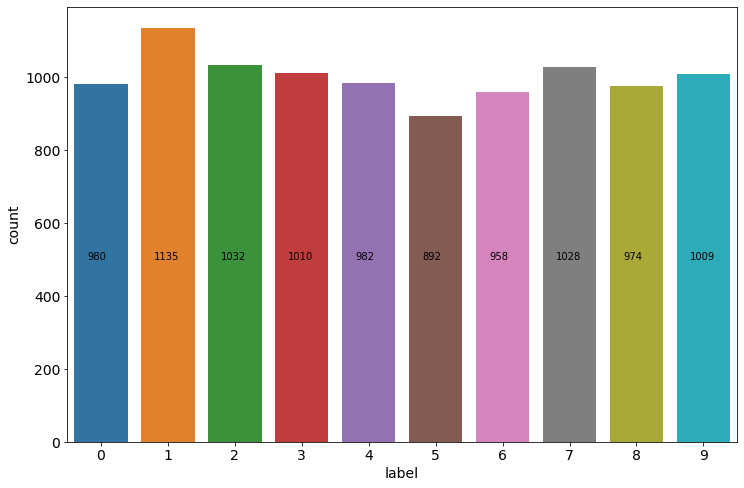

## Binary Classification
- [SGDClassfier: regularized linear models with stochastic gradient descent (SGD) learning](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [Cross Validation Score (cross_val_score)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val_score#sklearn.model_selection.cross_val_score)
- [sklearn.metrics.plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html?highlight=plot_confusion_matrix#sklearn.metrics.plot_confusion_matrix)

* 取 y_train == 9 及 y_test == 9 的 boolean 數據集

array([False, False, False, ..., False, False, False])

array([False, False, False, ..., False, False, False])

### 向感知器致敬

* 載入二元分類器 (Perceptron)

In [17]:
from sklearn.linear_model import Perceptron

* 訓練訓練集數據

(array([False]), False)

* 從 sklearn.metrics 載入 classification_report, plot_roc_curve, plot_confusion_matrix

In [26]:
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix

* 輸出 classification_report 結果

              precision    recall  f1-score   support

       False       0.98      0.96      0.97      8991
        True       0.71      0.85      0.77      1009

    accuracy                           0.95     10000
   macro avg       0.85      0.90      0.87     10000
weighted avg       0.96      0.95      0.95     10000



* 輸出 confusion_metrix

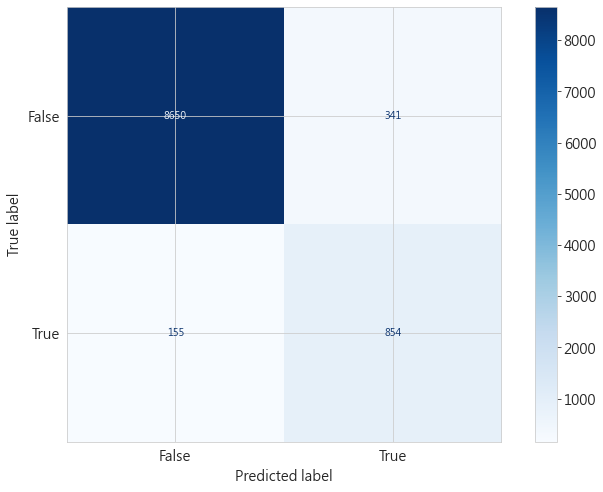

* 繪製 ROC curve

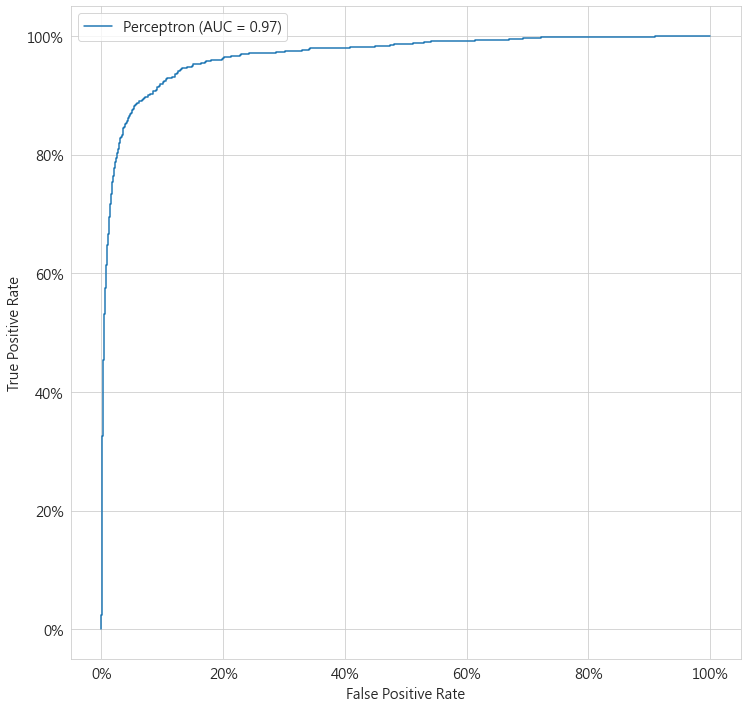

* 載入並輸出 交叉比對(cross_val_score)結果 (cv = 5)

[0.938  0.9385 0.95   0.938  0.9595]


### SGD Classifier

* 載入 SGDClassifier

In [44]:
from sklearn.linear_model import SGDClassifier

* 訓練SGD分類器模型 (max_iter = 1000, tol = 1e-3) \
訓練並輸出 classifiication report

              precision    recall  f1-score   support

       False       0.98      0.99      0.98      8991
        True       0.87      0.80      0.83      1009

    accuracy                           0.97     10000
   macro avg       0.92      0.89      0.91     10000
weighted avg       0.97      0.97      0.97     10000



* 輸出 confusion metrix

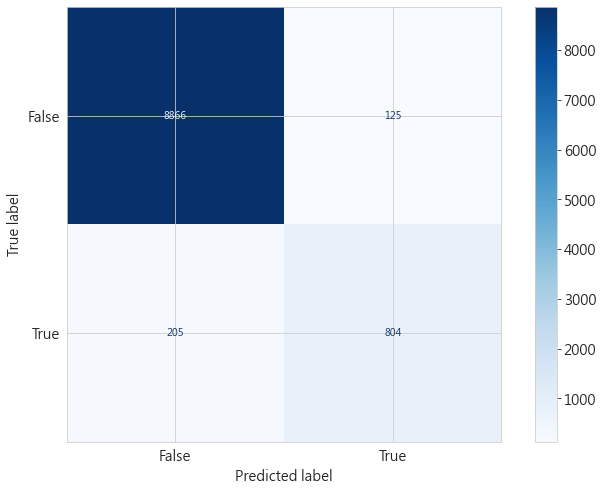

* 輸出 ROC curve

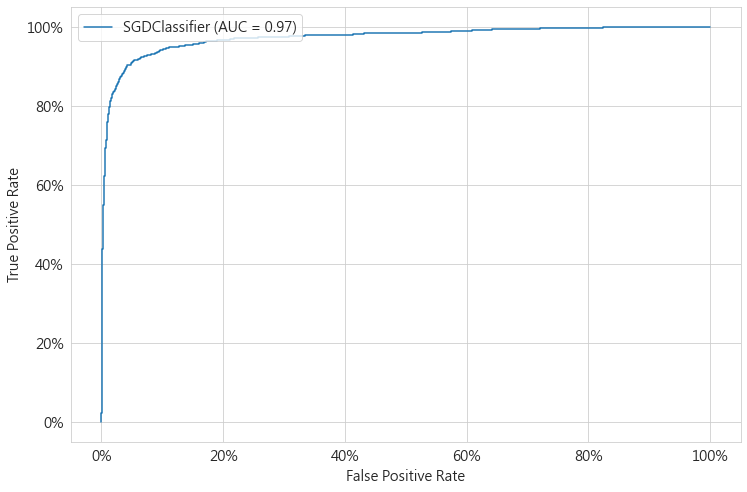

## Multi-class Classification

### Logistic Regression

- [sklearn: Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Linear Model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

* 載入 LogisticRegression(max_iter = 500) \
以LogisticRegression 訓練並分類數據集

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

0.9392166666666667
0.9257


C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.92      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



* 繪製 Confusion_matrix

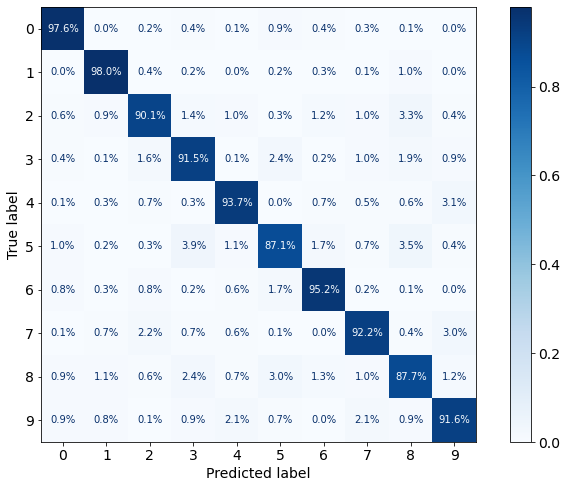

* 輸出各種class的判斷x_test[0]的機率

0 = 0.000%, y_test[0] = 7
1 = 0.000%, y_test[0] = 7
2 = 0.000%, y_test[0] = 7
3 = 0.258%, y_test[0] = 7
4 = 0.000%, y_test[0] = 7
5 = 0.001%, y_test[0] = 7
6 = 0.000%, y_test[0] = 7
7 = 99.720%, y_test[0] = 7
8 = 0.001%, y_test[0] = 7
9 = 0.020%, y_test[0] = 7


* 嘗試取出 100th 列數據分類結果，並輸出countplot(bar plot)

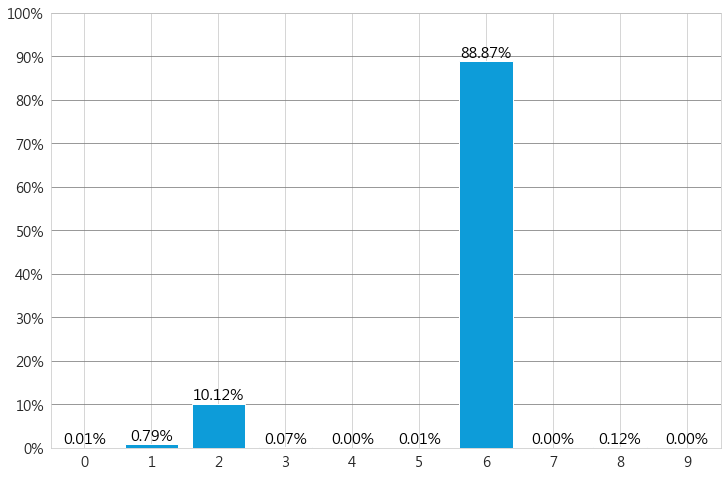

* 取出 200th 數據集的圖片，並輸出分類機率的長條圖

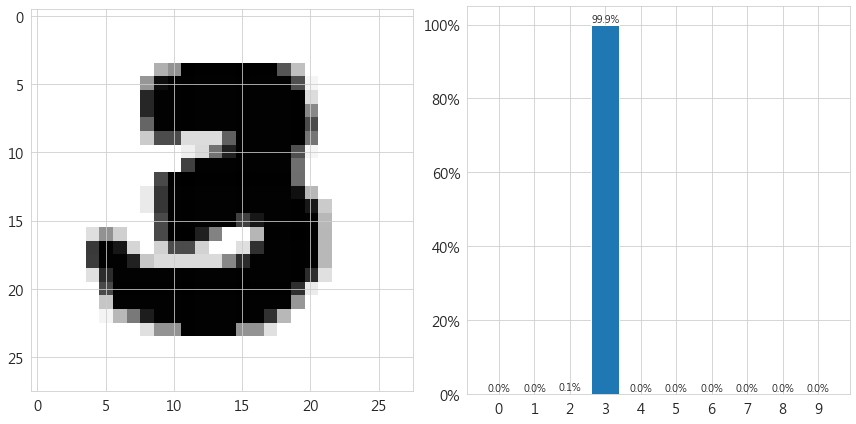

* 以副程式 predict_digit_viask 輸出 220th test data 結果

test set digit index [220]
answer = 7 , predicted = 7



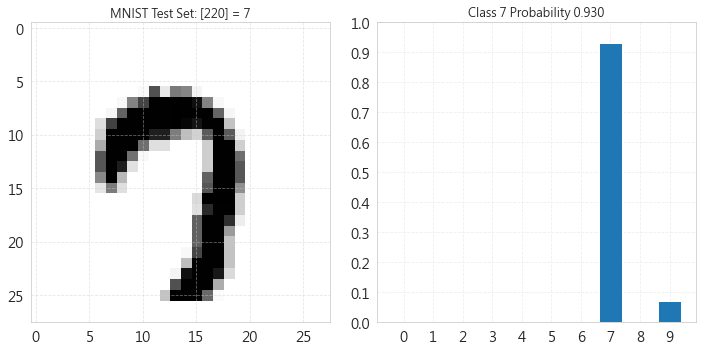

* 找出分類錯誤的數據

[8, 33, 63, 66, 124, 149, 193, 195, 211, 217, 233, 241, 245, 247, 259, 307, 313, 320, 321, 340, 344, 352, 362, 381, 403, 406, 412, 425, 435, 444, 445, 448, 469, 478, 479, 502, 507, 528, 531, 536, 542, 543, 551, 565, 569, 578, 582, 583, 591, 613, 619, 629, 659, 684, 691, 692, 707, 717, 720, 728, 740, 741, 760, 781, 791, 829, 839, 844, 857, 877, 881, 882, 890, 898, 924, 938, 939, 947, 950, 951, 956, 959, 965, 975, 999, 1003, 1012, 1014, 1017, 1028, 1032, 1039, 1044, 1062, 1068, 1082, 1101, 1107, 1112, 1114, 1128, 1157, 1178, 1181, 1182, 1191, 1192, 1194, 1198, 1202, 1204, 1206, 1226, 1232, 1233, 1234, 1242, 1247, 1256, 1260, 1283, 1299, 1310, 1319, 1320, 1325, 1326, 1337, 1364, 1378, 1393, 1410, 1413, 1433, 1440, 1444, 1466, 1494, 1500, 1522, 1525, 1527, 1530, 1549, 1553, 1559, 1569, 1581, 1587, 1609, 1634, 1640, 1681, 1686, 1696, 1709, 1717, 1718, 1722, 1751, 1754, 1765, 1772, 1773, 1774, 1790, 1800, 1813, 1828, 1850, 1855, 1878, 1883, 1899, 1901, 1917, 1926, 1938, 1940, 1941, 1942, 195

* 計算總共錯誤幾個數據點

743

* 輸出前五個錯誤的數據集

test set digit index [8]
answer = 5 , predicted = 6

test set digit index [33]
answer = 4 , predicted = 6

test set digit index [63]
answer = 3 , predicted = 2

test set digit index [66]
answer = 6 , predicted = 2

test set digit index [124]
answer = 7 , predicted = 4



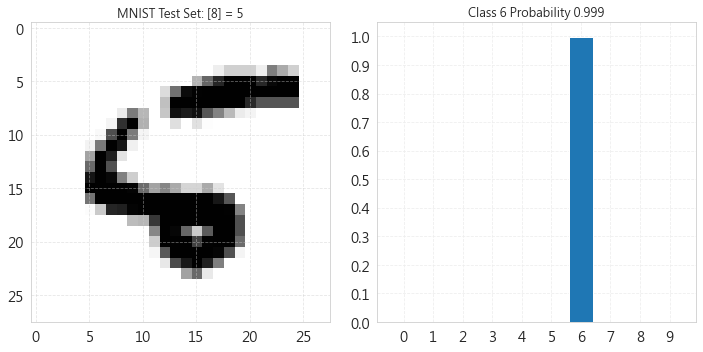

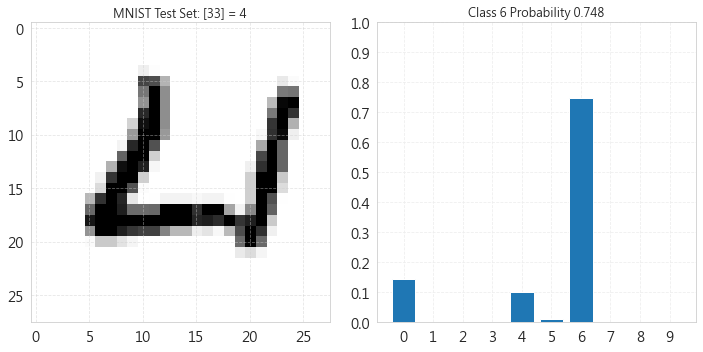

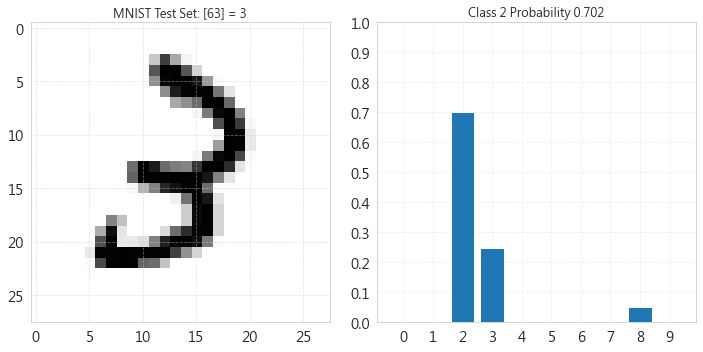

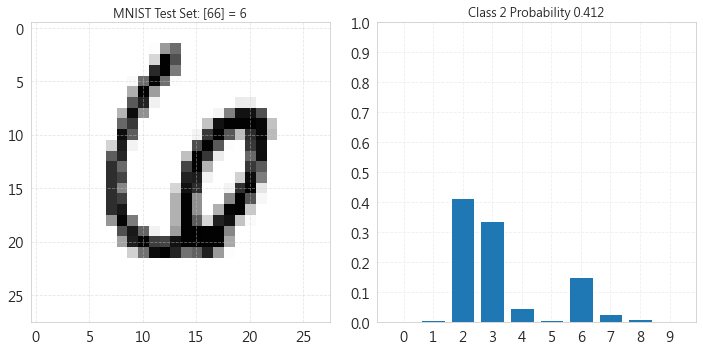

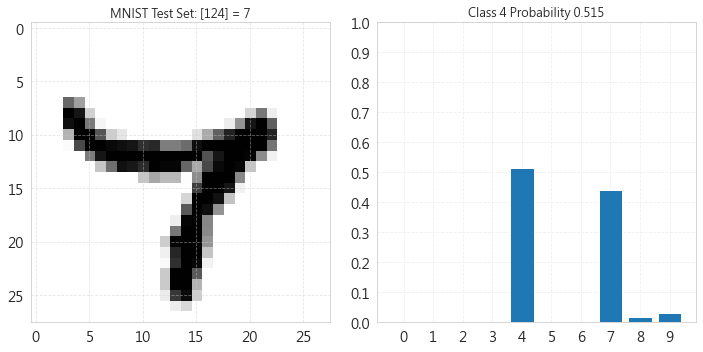

### YellowBrick ClassificationReport

- [YellowBrick](https://www.scikit-yb.org/en/latest/quickstart.html) [ClassificationReport](https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html) API



* 嘗試以 YellowBrick 輸出結果

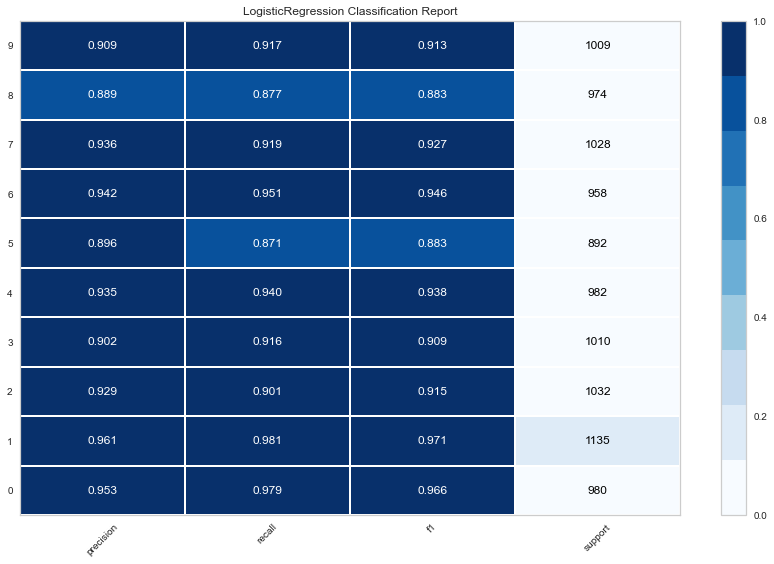

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

### mlxtend plot_confusion_matrix

- mlxtend [plot_confusion_matrix](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/) user guide

(Google Colab 提供的版本太舊，需要自行安裝最新版)

```
!pip3 install --upgrade mlxtend
```

* mlxtend.plotting 輸出 confusion_matrix

[]


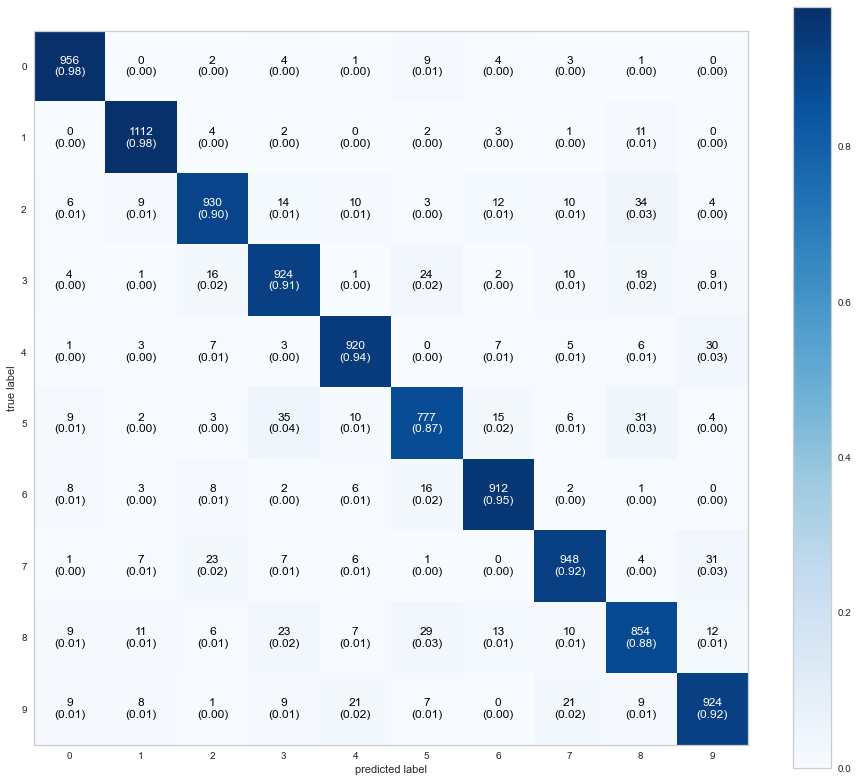

#### same as sklearn, but more sphiscated

### k-Nearest Neighbor

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Multi Layer Perceptron

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Wall time: 43.7 s


### SVM

- [sklearn Support Vector Machines](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)

Classification Report: SVC(kernel = 'Linear')
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.93      0.94      0.93      1032
           3       0.91      0.94      0.92      1010
           4       0.93      0.96      0.95       982
           5       0.92      0.90      0.91       892
           6       0.96      0.95      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.94      0.90      0.92       974
           9       0.95      0.91      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



------------------------------------------------------------
Classification Report: LinearSVC()
              precision    recall  f1-score   support

           0       0.95      0.98      0.9

# 下一個單元

- https://reurl.cc/g7y7Ab